# Bayesian Clustering and Smoothing of Carbon Emissions Time Series

The code file for the chapter on ***Bayesian Clustering and Smoothing of Carbon Emissions Time Series***

The part 1 section of this file consists of all the trails and experiments we did to have hands on experience with smoothing and hyperparameter tuning. This helped us to understand how the features work and make choices tht are data driven.
In case we are interested to tune further we can proceed with the code in part 1. Else, it can be skipped and the part 2 section of the file consists of the complete code workflow that was used to build the analysis for this chapter.

The csv file to be mapped is named as Europe_Carbon_Monitor_Final.csv and is present in Final Datasets folder in the Zip file

# Part - 1 Smoothing and Clustering Trails

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Load the dataset
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")

# Convert date to datetime
EU_data['date'] = pd.to_datetime(EU_data['date'])

# Optional: inspect for NaNs and drop or impute if needed
print(EU_data.isna().sum())
EU_data.dropna(inplace=True)

country                   0
date                      0
Domestic Aviation         0
Ground Transport          0
Industry                  0
International Aviation    0
Power                     0
Residential               0
dtype: int64


## Preprocessing

In [ ]:
countries = EU_data['country'].unique()
print(countries)

['Austria' 'Belgium' 'Bulgaria' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'EU27 & UK' 'Estonia' 'Finland' 'France' 'Germany' 'Greece'
 'Hungary' 'Ireland' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta'
 'Netherlands' 'Norway' 'Poland' 'Portugal' 'Romania' 'Slovakia'
 'Slovenia' 'Spain' 'Sweden' 'Switzerland' 'United Kingdom']


In [ ]:
EU_data = EU_data[EU_data['country'] != 'EU27 & UK']
EU_data.dropna(inplace=True)

EU_data['t'] = EU_data.groupby('country')['date'].transform(lambda x: np.arange(len(x)))
countries = EU_data['country'].unique()
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry', 'International Aviation', 'Power', 'Residential']


<ipython-input-28-d4255932ff4f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-d4255932ff4f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## B Spline

Applying B-spline smoothing on the EU data

In [ ]:
smooth_features = {}

for country in countries:
    country_data = EU_data[EU_data['country'] == country].copy()
    features = []
    for sector in sectors:
        spline_basis = dmatrix("bs(t, df=20, degree=3, include_intercept=True) - 1",
                               {"t": country_data['t']}, return_type='dataframe')
        y = country_data[sector].values
        ridge = Ridge(alpha=0.1, fit_intercept=False)
        ridge.fit(spline_basis, y)
        features.extend(ridge.coef_)
    smooth_features[country] = features

X = pd.DataFrame.from_dict(smooth_features, orient='index')
X.columns = [f"{sec}_coef_{i}" for sec in sectors for i in range(20)]
X.index.name = 'country'


In [ ]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Spline effect on a Country-sector

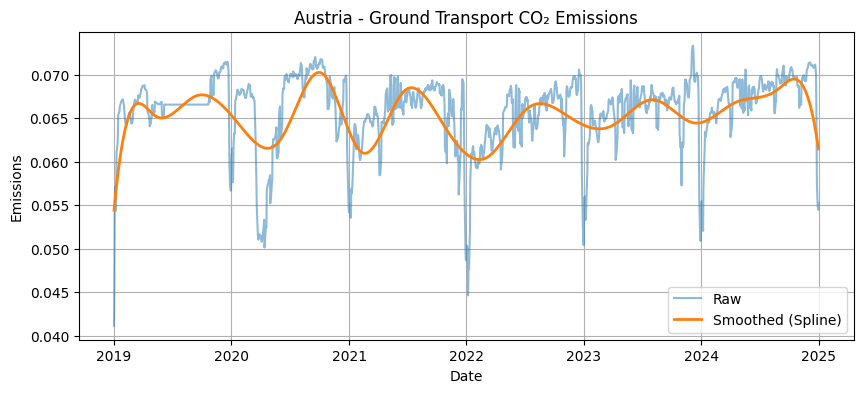

In [ ]:
# Visualizin spline effect for a specific country
def plot_spline_effect(country="Austria", sector="Ground Transport"):
    df_country = EU_data[EU_data["country"] == country].copy()
    t = df_country['t'].values
    y = df_country[sector].values
    spline_basis = dmatrix("bs(t, df=20, degree=3, include_intercept=True) - 1",
                           {"t": t}, return_type='dataframe')
    ridge = Ridge(alpha=1.0, fit_intercept=False)
    ridge.fit(spline_basis, y)
    y_smooth = ridge.predict(spline_basis)

    plt.figure(figsize=(10,4))
    plt.plot(df_country['date'], y, label='Raw', alpha=0.5)
    plt.plot(df_country['date'], y_smooth, label='Smoothed (Spline)', linewidth=2)
    plt.title(f"{country} - {sector} CO₂ Emissions")
    plt.xlabel("Date")
    plt.ylabel("Emissions")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_spline_effect()  # We can Customize country/sector as needed


### Spline on for all sectors for a country

In [ ]:
def plot_all_sectors_spline(country_name):
    import matplotlib.pyplot as plt
    from patsy import dmatrix
    from sklearn.linear_model import Ridge

    df = EU_data[EU_data["country"] == country_name].copy()
    df['t'] = np.arange(len(df))

    sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
               'International Aviation', 'Power', 'Residential']

    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    axs = axs.flatten()

    for i, sector in enumerate(sectors):
        t = df['t'].values
        y = df[sector].values
        basis = dmatrix("bs(t, df=20, degree=3, include_intercept=True) - 1", {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=0.1, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        axs[i].plot(df['date'], y, label="Raw", alpha=0.5)
        axs[i].plot(df['date'], y_smooth, label="Spline", color='orange', linewidth=2)
        axs[i].set_title(f"{country_name} - {sector}")
        axs[i].grid(True)
        axs[i].legend()

    plt.suptitle(f"Spline Smoothing for All Sectors - {country_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


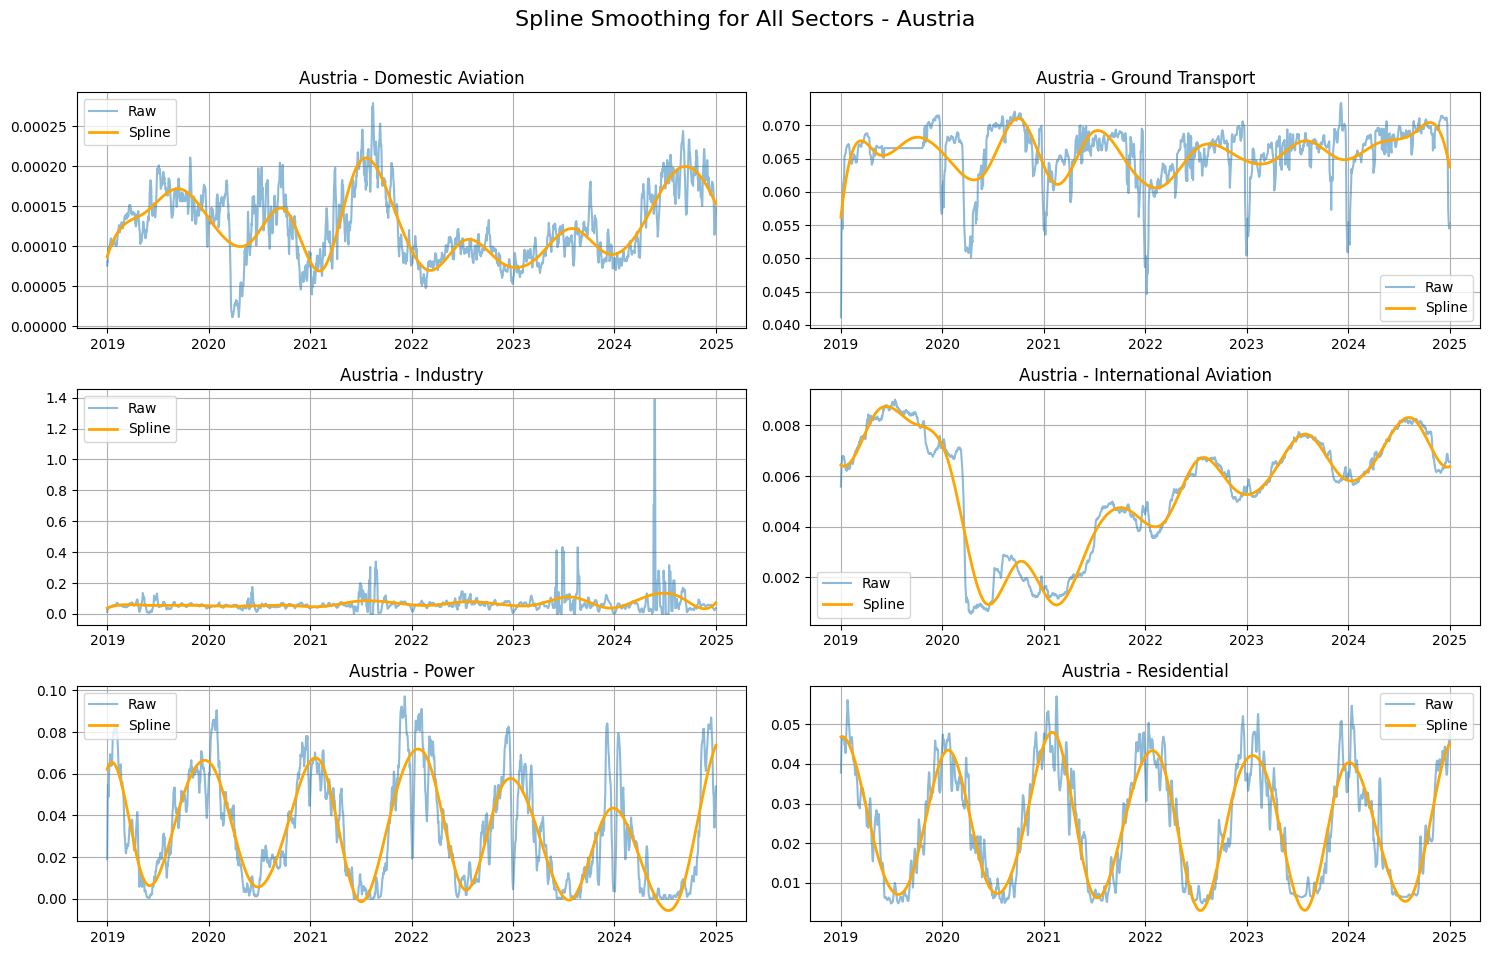

In [ ]:
plot_all_sectors_spline("Austria")


### Interactive Spline Tuning

This was created to see the effects of changing parameters on smoothing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrix
from sklearn.linear_model import Ridge
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown


In [ ]:
def interactive_spline(country, sector, df, degree, alpha):
    df_country = EU_data[EU_data["country"] == country].copy()
    df_country['t'] = np.arange(len(df_country))

    t = df_country['t'].values
    y = df_country[sector].values

    # Spline basis
    spline_basis = dmatrix(f"bs(t, df={df}, degree={degree}, include_intercept=True) - 1",
                           {"t": t}, return_type='dataframe')

    # Ridge regression on basis
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(spline_basis, y)
    y_smooth = ridge.predict(spline_basis)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(df_country['date'], y, label='Raw', alpha=0.5)
    plt.plot(df_country['date'], y_smooth, label='Smoothed', color='orange', linewidth=2)
    plt.title(f"{country} - {sector} Emissions (df={df}, degree={degree}, alpha={alpha})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
interact(
    interactive_spline,
    country=Dropdown(options=EU_data['country'].unique(), value='Austria', description='Country:'),
    sector=Dropdown(options=['Domestic Aviation', 'Ground Transport', 'Industry', 'International Aviation', 'Power', 'Residential'], value='Ground Transport', description='Sector:'),
    df=IntSlider(min=5, max=40, step=1, value=20, description='df (flexibility)'),
    degree=IntSlider(min=1, max=5, step=1, value=3, description='Degree'),
    alpha=FloatSlider(min=0.01, max=10.0, step=0.1, value=1.0, description='Alpha (smooth)')
)


interactive(children=(Dropdown(description='Country:', options=('Austria', 'Belgium', 'Bulgaria', 'Croatia', '…

<function __main__.interactive_spline(country, sector, df, degree, alpha)>

## Optimal Clusters with B-spline Features

Frequentist clustering models would require the optimal number of clusters to be pre defined. For the purpose of choosing the optimal number of clusters that can help us with country level clustering we shall perform GMM on the splined features along with BIC and Silhouette score.

### BIC and Sil with GMM

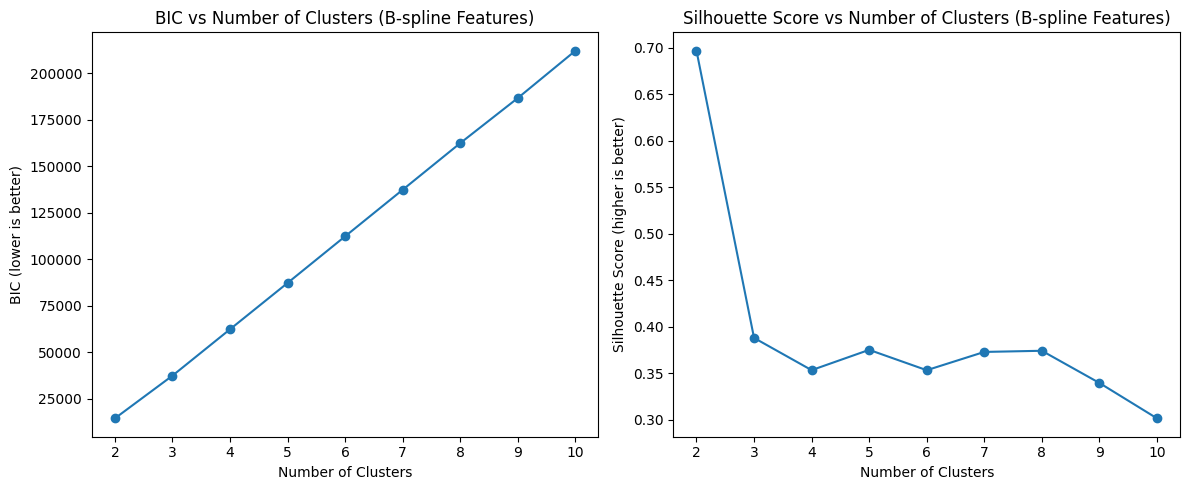

In [ ]:
bic_scores, silhouette_scores = [], []
n_components_range = range(2, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    labels = gmm.predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC vs Number of Clusters (B-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC (lower is better)')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (B-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score (higher is better)')
plt.tight_layout()
plt.show()

In [ ]:
print("Number of Clusters | BIC Score       | Silhouette Score")
print("-" * 55)
for k, bic, sil in zip(n_components_range, bic_scores, silhouette_scores):
    print(f"{k:<18} | {bic:<15.2f} | {sil:.4f}")


Number of Clusters | BIC Score       | Silhouette Score
-------------------------------------------------------
2                  | 14367.56        | 0.6969
3                  | 37318.09        | 0.3879
4                  | 62254.54        | 0.3532
5                  | 87156.94        | 0.3750
6                  | 112227.42       | 0.3532
7                  | 137259.33       | 0.3728
8                  | 162329.22       | 0.3741
9                  | 186562.21       | 0.3394
10                 | 211987.01       | 0.3014


### GMM with optimal n

In [ ]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
X['GMM_Cluster'] = gmm.predict(X_scaled)


### BGMM with optimal n

In [ ]:
bgmm = BayesianGaussianMixture(
    n_components=2,
    weight_concentration_prior=0.5,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
)
bgmm.fit(X_scaled)
X['Bayesian_Cluster'] = bgmm.predict(X_scaled)


In [ ]:
used = np.sum(bgmm.weights_ > 1e-2)
print(f"Active Clusters Used: {used}")


Active Clusters Used: 2


### Comparison

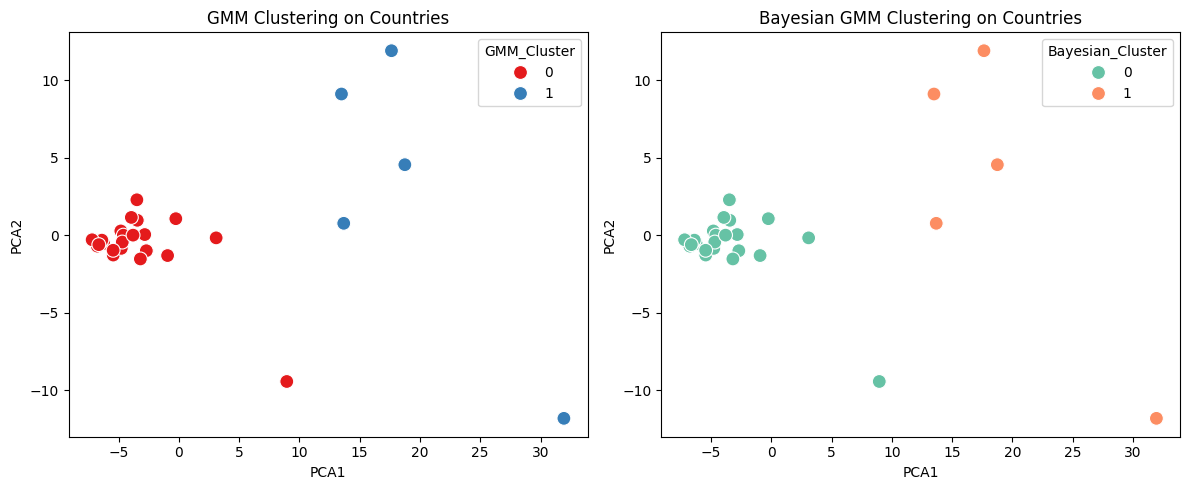

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['PCA1'], X['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=X, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='Set1', s=100)
plt.title("GMM Clustering on Countries")

plt.subplot(1, 2, 2)
sns.scatterplot(data=X, x='PCA1', y='PCA2', hue='Bayesian_Cluster', palette='Set2', s=100)
plt.title("Bayesian GMM Clustering on Countries")
plt.tight_layout()
plt.show()

In [ ]:
# Step 9: Cluster Members
for cluster in sorted(X['Bayesian_Cluster'].unique()):
    print(f"\nBayesian Cluster {cluster}:")
    print(X[X['Bayesian_Cluster'] == cluster].index.tolist())


Bayesian Cluster 0:
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'Greece', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

Bayesian Cluster 1:
['France', 'Germany', 'Italy', 'Spain', 'United Kingdom']


In [ ]:
# Step 9: Cluster Members
for cluster in sorted(X['GMM_Cluster'].unique()):
    print(f"\nGMM Cluster {cluster}:")
    print(X[X['GMM_Cluster'] == cluster].index.tolist())


GMM Cluster 0:
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'Greece', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

GMM Cluster 1:
['France', 'Germany', 'Italy', 'Spain', 'United Kingdom']


“Clustering was performed using both Gaussian Mixture Models (GMM) and Bayesian Gaussian Mixture Models (BGMM) on B- spline-derived features. Silhouette scores and BIC indicated an optimal cluster number of K = 2, with both models producing nearly identical cluster assignments. This validated the robustness of the latent structure inferred from the spline-based time series features.”


### BGMM Cluster Viz

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [ ]:
# bgmm and X_scaled are already defined from previous code steps
# Posterior probabilities (rows: countries, columns: clusters)
posterior_probs = bgmm.predict_proba(X_scaled)
cluster_probs_df = pd.DataFrame(posterior_probs, index=X.index)
cluster_probs_df.columns = [f'Cluster_{i}' for i in range(cluster_probs_df.shape[1])]

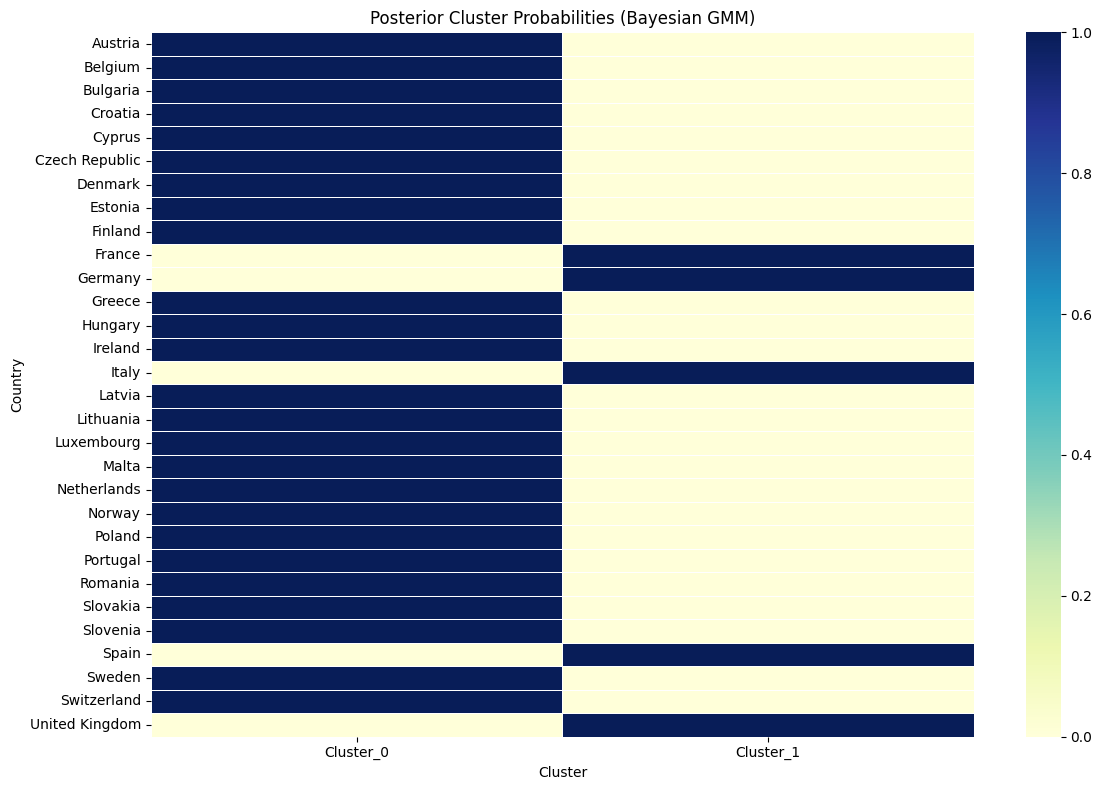

In [ ]:
# Visualizing posterior probabilities as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_probs_df, cmap="YlGnBu", annot=False, linewidths=0.5)
plt.title("Posterior Cluster Probabilities (Bayesian GMM)")
plt.xlabel("Cluster")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

In [ ]:
# Checking how many clusters are active (non-trivial weight)
active_clusters = np.sum(bgmm.weights_ > 0.01)
print(f"Active Clusters Used: {active_clusters}")
print("Cluster Weights:")
for i, w in enumerate(bgmm.weights_):
    if w > 0.01:
        print(f"Cluster {i}: Weight = {w:.4f}")

Active Clusters Used: 2
Cluster Weights:
Cluster 0: Weight = 0.8366
Cluster 1: Weight = 0.1634


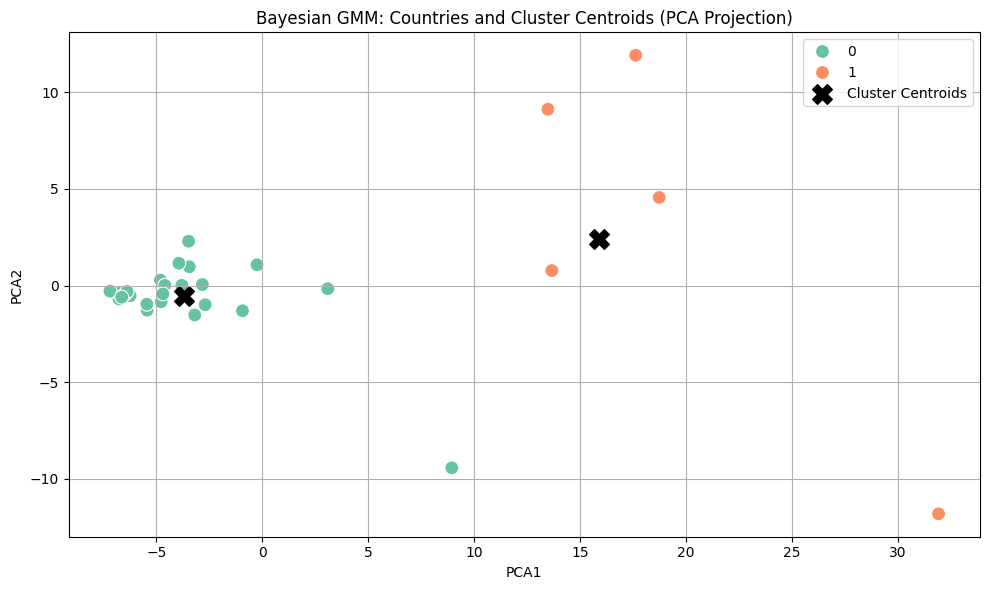

In [ ]:
#Visualizing mean vectors for each active cluster
# We'll reshape and plot the mean trajectories per cluster for interpretability
means = bgmm.means_[:active_clusters]

# Optional: reverse standardization to get approximate original scale
# (if needed for interpretation, here we keep them as normalized features)

# Each mean is over spline coefficients; difficult to interpret raw
# Instead, we compare country means vs. cluster means in PCA space (projection)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['PCA1'], X['PCA2'] = X_pca[:, 0], X_pca[:, 1]
cluster_means_pca = pca.transform(bgmm.means_[:active_clusters])

# Ploting PCA of countries and cluster centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Bayesian_Cluster', data=X, palette='Set2', s=100, legend='full')
plt.scatter(cluster_means_pca[:, 0], cluster_means_pca[:, 1], c='black', s=200, marker='X', label='Cluster Centroids')
plt.title("Bayesian GMM: Countries and Cluster Centroids (PCA Projection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Identifying countries with uncertain assignment
threshold = 0.80
uncertain_countries = cluster_probs_df[cluster_probs_df.max(axis=1) < threshold]
print(f"\nCountries with uncertain cluster membership (max prob < {threshold}):")
print(uncertain_countries.index.tolist())



Countries with uncertain cluster membership (max prob < 0.8):
[]


The posterior analysis of BGMM further confirmed confident cluster membership for all countries, with no ambiguous assignments (not less than 80% posterior probability), indicating a strong separation of emission behavior across the selected spline representation.”

## P Spline

Applying P-spline smoothing on the EU data. We shall reload the dataset to avoid ambiguity with the effects of B-spline smoothing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from patsy import dmatrix

In [ ]:
# Load the dataset
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")

# Convert date to datetime
EU_data['date'] = pd.to_datetime(EU_data['date'])

EU_data = EU_data[EU_data['country'] != 'EU27 & UK']
EU_data.dropna(inplace=True)
EU_data['t'] = EU_data.groupby('country')['date'].transform(lambda x: np.arange(len(x)))

Defining a function to apply P-spline smoothing that can be used once we have tha parameters selected

In [ ]:
# P-spline-like smoothing using B-splines + Ridge (penalized regression)
def extract_pspline_features(df, sectors, df_spline=20, alpha=1.0):
    countries = df['country'].unique()
    smooth_features = {}

    for country in countries:
        country_data = df[df['country'] == country].copy()
        features = []
        for sector in sectors:
            # B-spline basis
            spline_basis = dmatrix(f"bs(t, df={df_spline}, degree=3, include_intercept=True) - 1",
                                   {"t": country_data['t']}, return_type='dataframe')
            y = country_data[sector].values

            # Ridge regression as P-spline approximation
            ridge = Ridge(alpha=alpha, fit_intercept=False)
            ridge.fit(spline_basis, y)
            features.extend(ridge.coef_)  # Use spline coefficients as features

        smooth_features[country] = features

    X = pd.DataFrame.from_dict(smooth_features, orient='index')
    X.columns = [f"{sec}_coef_{i}" for sec in sectors for i in range(df_spline)]
    X.index.name = 'country'
    return X

### Spline effect on a Country-sector

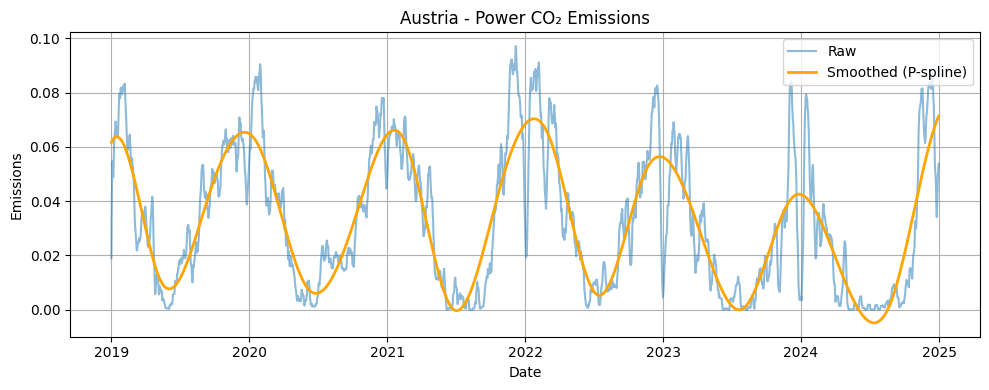

In [ ]:
def plot_spline_effect(country="Austria", sector="Power", df_spline=20, degree=3, alpha=1.0):
    df_country = EU_data[EU_data["country"] == country].copy()
    df_country['t'] = np.arange(len(df_country))

    t = df_country['t'].values
    y = df_country[sector].values

    spline_basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                           {"t": t}, return_type='dataframe')
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(spline_basis, y)
    y_smooth = ridge.predict(spline_basis)

    plt.figure(figsize=(10, 4))
    plt.plot(df_country['date'], y, label='Raw', alpha=0.5)
    plt.plot(df_country['date'], y_smooth, label='Smoothed (P-spline)', linewidth=2, color='orange')
    plt.title(f"{country} - {sector} CO₂ Emissions")
    plt.xlabel("Date")
    plt.ylabel("Emissions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_spline_effect()

***Plotly version***

In [ ]:
import plotly.graph_objects as go
from sklearn.linear_model import Ridge
from patsy import dmatrix
import numpy as np

def plot_spline_effect_plotly(df, country="Austria", sector="Power", df_spline=20, degree=3, alpha=1.0):
    df_country = df[df["country"] == country].copy()
    df_country = df_country.sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    t = df_country['t'].values
    y = df_country[sector].values

    # Create spline basis
    spline_basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                           {"t": t}, return_type='dataframe')

    # Ridge regression (P-spline)
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(spline_basis, y)
    y_smooth = ridge.predict(spline_basis)

    # Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_country['date'], y=y, mode='lines',
                             name='Raw Emissions', line=dict(color='gray', dash='dot'),
                             opacity=0.6))

    fig.add_trace(go.Scatter(x=df_country['date'], y=y_smooth, mode='lines',
                             name='Smoothed (P-spline)',
                             line=dict(color='orange', width=2)))

    fig.update_layout(
        title=f"{country} - {sector} CO₂ Emissions (P-spline Smoothing)",
        xaxis_title="Date",
        yaxis_title="Emissions (MtCO₂)",
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
        height=400
    )

    fig.show()


plot_spline_effect_plotly(EU_data, country="Austria", sector="Power")


### Spline on all sectors for a country

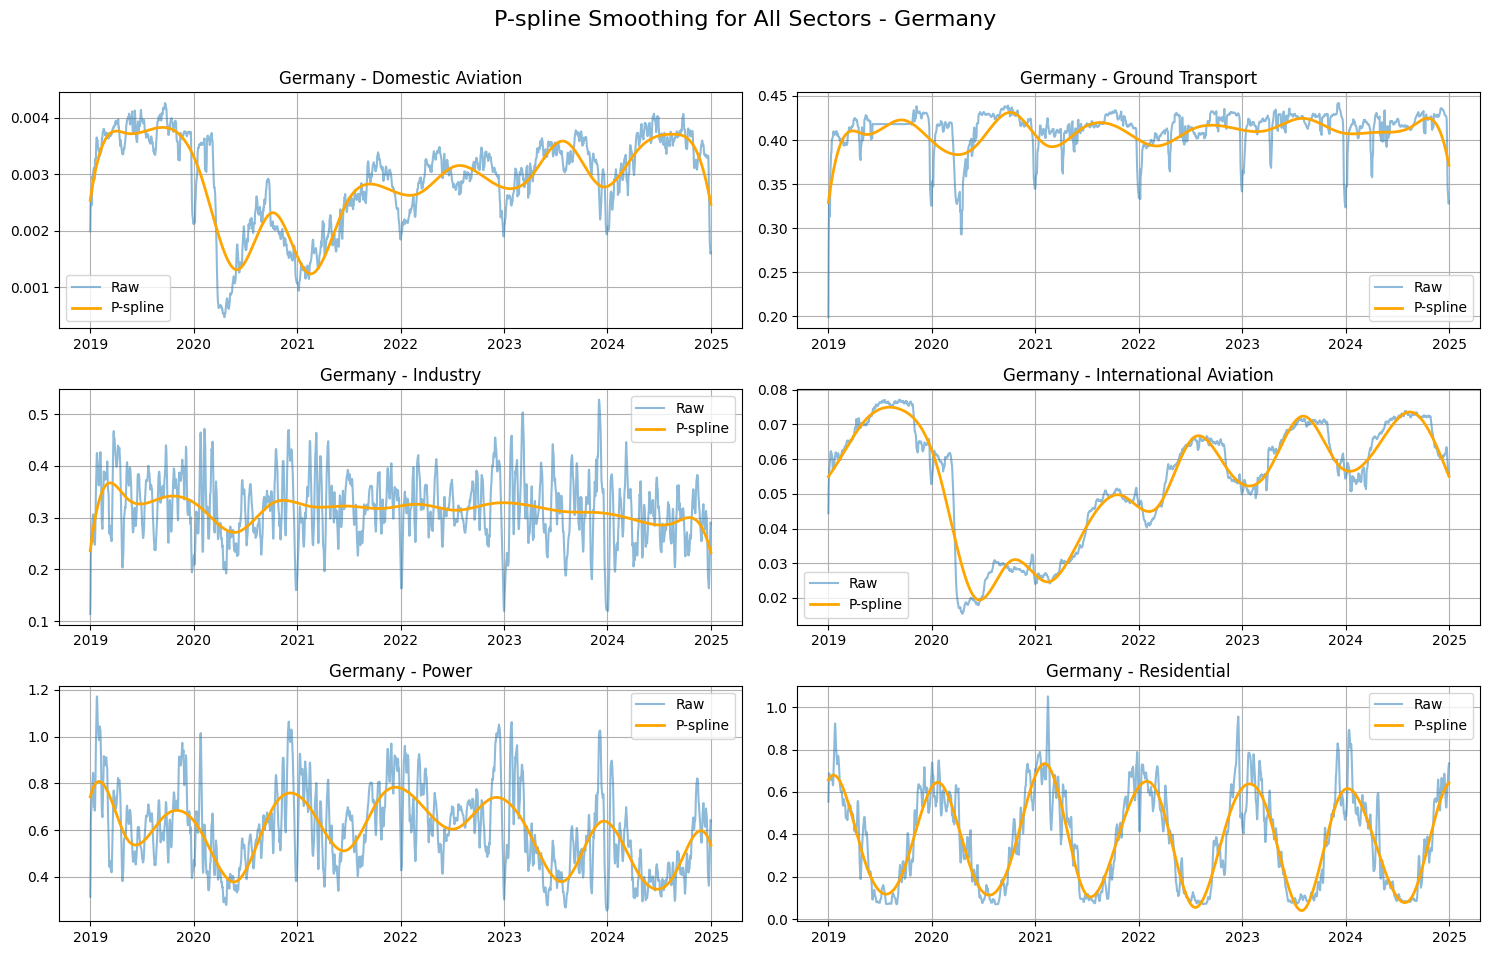

In [ ]:
def plot_all_sectors_spline(country_name, df_spline=20, degree=3, alpha=1.0):
    df = EU_data[EU_data["country"] == country_name].copy()
    df['t'] = np.arange(len(df))
    sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
               'International Aviation', 'Power', 'Residential']

    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    axs = axs.flatten()

    for i, sector in enumerate(sectors):
        t = df['t'].values
        y = df[sector].values
        basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                        {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        axs[i].plot(df['date'], y, label="Raw", alpha=0.5)
        axs[i].plot(df['date'], y_smooth, label="P-spline", color='orange', linewidth=2)
        axs[i].set_title(f"{country_name} - {sector}")
        axs[i].grid(True)
        axs[i].legend()

    plt.suptitle(f"P-spline Smoothing for All Sectors - {country_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


plot_all_sectors_spline("Germany")

***Plotly version for dashboard***

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from patsy import dmatrix
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_all_sectors_spline_subplots_no_legend(df, country_name, df_spline=20, degree=3, alpha=1.0):
    df_country = df[df["country"] == country_name].copy()
    df_country = df_country.sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
               'International Aviation', 'Power', 'Residential']
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']

    fig = make_subplots(rows=3, cols=2, subplot_titles=sectors)

    for i, sector in enumerate(sectors):
        t = df_country['t'].values
        y = df_country[sector].values
        date = df_country['date']

        basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                        {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        row = i // 2 + 1
        col = i % 2 + 1

        fig.add_trace(go.Scatter(x=date, y=y, mode='lines',
                                 line=dict(dash='dot', width=1),
                                 showlegend=False),
                      row=row, col=col)
        fig.add_trace(go.Scatter(x=date, y=y_smooth, mode='lines',
                                 line=dict(color=colors[i], width=2),
                                 showlegend=False),
                      row=row, col=col)

    fig.update_layout(
        height=900,
        width=1000,
        title_text=f"P-spline Smoothing for All Sectors - {country_name}",
        template="plotly_white",
        showlegend=False  # 🔻 disables the legend
    )

    fig.show()

plot_all_sectors_spline_subplots_no_legend(EU_data, "Germany")


All sectors in one plot

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from patsy import dmatrix
import plotly.graph_objects as go

def plot_all_sectors_spline_plotly(df, country_name, df_spline=20, degree=3, alpha=1.0):
    df = df[df["country"] == country_name].copy()
    df = df.sort_values("date").reset_index(drop=True)
    df['t'] = np.arange(len(df))

    sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
               'International Aviation', 'Power', 'Residential']

    fig = go.Figure()
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']

    for i, sector in enumerate(sectors):
        t = df['t'].values
        y = df[sector].values
        date = df['date']

        basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                        {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        fig.add_trace(go.Scatter(x=date, y=y, mode='lines',
                                 name=f'{sector} Raw',
                                 opacity=0.4, line=dict(dash='dot')))
        fig.add_trace(go.Scatter(x=date, y=y_smooth, mode='lines',
                                 name=f'{sector} Smoothed',
                                 line=dict(color=colors[i], width=2)))

    fig.update_layout(
        title=f"P-spline Smoothing for All Sectors - {country_name}",
        xaxis_title="Date",
        yaxis_title="Emissions (MtCO2)",
        template="plotly_white",
        #legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5)
    )

    fig.show()


plot_all_sectors_spline_plotly(EU_data, "Italy")


### Interactive Spline Tuning

This was created to see the effects of changing parameters on smoothing

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

def interactive_spline(country, sector, df_spline, degree, alpha):
    df_country = EU_data[EU_data["country"] == country].copy()
    df_country['t'] = np.arange(len(df_country))

    t = df_country['t'].values
    y = df_country[sector].values

    spline_basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                           {"t": t}, return_type='dataframe')

    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(spline_basis, y)
    y_smooth = ridge.predict(spline_basis)

    plt.figure(figsize=(10, 4))
    plt.plot(df_country['date'], y, label='Raw', alpha=0.5)
    plt.plot(df_country['date'], y_smooth, label='P-spline', color='orange', linewidth=2)
    plt.title(f"{country} - {sector} Emissions (df={df_spline}, degree={degree}, alpha={alpha})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

interact(
    interactive_spline,
    country=Dropdown(options=EU_data['country'].unique(), value='Austria', description='Country:'),
    sector=Dropdown(options=['Domestic Aviation', 'Ground Transport', 'Industry', 'International Aviation', 'Power', 'Residential'], value='Ground Transport', description='Sector:'),
    df_spline=IntSlider(min=5, max=40, step=1, value=20, description='df (flexibility)'),
    degree=IntSlider(min=1, max=5, step=1, value=3, description='Degree'),
    alpha=FloatSlider(min=0.01, max=10.0, step=0.1, value=1.0, description='Alpha (smooth)')
)


interactive(children=(Dropdown(description='Country:', options=('Austria', 'Belgium', 'Bulgaria', 'Croatia', '…

<function __main__.interactive_spline(country, sector, df_spline, degree, alpha)>

## Optimal Clusters with P-spline Features

This time we shall try a different procedure instead of finding optimal n and then feeding it to the BGMM we will use Dirichlet process to find the clusters from the data.

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']
X_pspline = extract_pspline_features(EU_data, sectors, df_spline=20, alpha=1.0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pspline)


### BIC and Sil with GMM

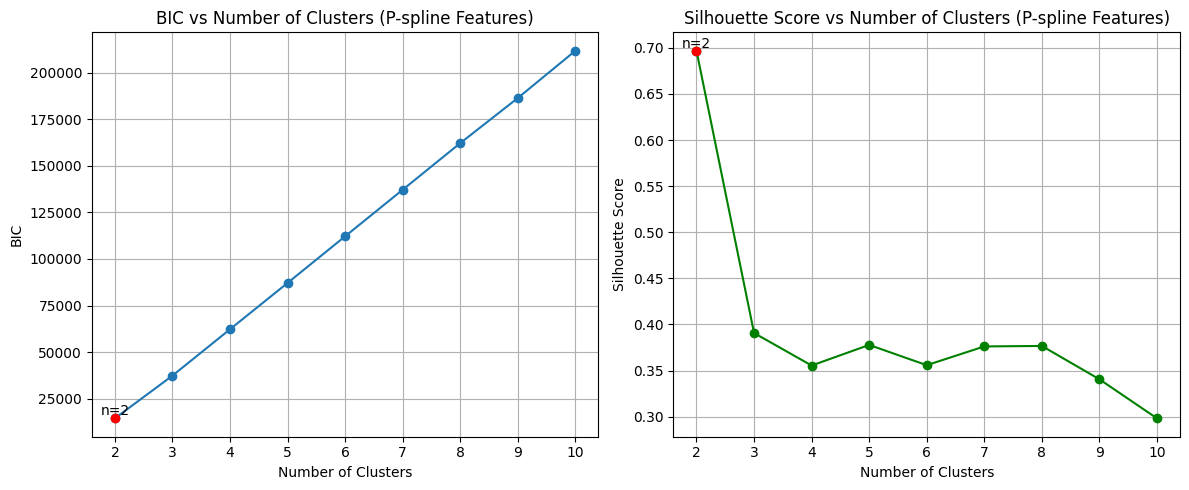

Best BIC at n=2: 14338.21
Best Silhouette Score at n=2: 0.6969


In [ ]:
bic_scores, silhouette_scores = [], []
n_components_range = range(2, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    bic_scores.append(gmm.bic(X_scaled))
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Identify optimal values
optimal_bic_n = n_components_range[np.argmin(bic_scores)]
optimal_sil_n = n_components_range[np.argmax(silhouette_scores)]

# Plot results
plt.figure(figsize=(12, 5))

# BIC Plot
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.scatter(optimal_bic_n, min(bic_scores), color='red', zorder=5)
plt.text(optimal_bic_n, min(bic_scores), f"n={optimal_bic_n}", va='bottom', ha='center')
plt.title('BIC vs Number of Clusters (P-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.grid(True)

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(n_components_range, silhouette_scores, marker='o', color='green', label='Silhouette')
plt.scatter(optimal_sil_n, max(silhouette_scores), color='red', zorder=5)
plt.text(optimal_sil_n, max(silhouette_scores), f"n={optimal_sil_n}", va='bottom', ha='center')
plt.title('Silhouette Score vs Number of Clusters (P-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Best BIC at n={optimal_bic_n}: {min(bic_scores):.2f}")
print(f"Best Silhouette Score at n={optimal_sil_n}: {max(silhouette_scores):.4f}")


In [ ]:
print("Number of Clusters | BIC Score       | Silhouette Score")
print("-" * 55)
for k, bic, sil in zip(n_components_range, bic_scores, silhouette_scores):
    print(f"{k:<18} | {bic:<15.2f} | {sil:.4f}")


Number of Clusters | BIC Score       | Silhouette Score
-------------------------------------------------------
2                  | 14338.21        | 0.6969
3                  | 37301.41        | 0.3907
4                  | 62237.99        | 0.3554
5                  | 87141.08        | 0.3778
6                  | 112211.57       | 0.3558
7                  | 137243.51       | 0.3762
8                  | 162313.49       | 0.3767
9                  | 186548.56       | 0.3405
10                 | 211973.91       | 0.2982


### GMM with n

In [ ]:
# Classical GMM clustering using best K
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
X_pspline['GMM_Cluster'] = gmm.predict(X_scaled)

### BGMM with Dirichlet Process to find n

In [ ]:
# Bayesian GMM clustering
bgmm = BayesianGaussianMixture(n_components=10,
                               weight_concentration_prior=0.5,
                               weight_concentration_prior_type='dirichlet_process',
                               covariance_type='full',
                               max_iter=1000,
                               random_state=42)
bgmm.fit(X_scaled)
X_pspline['Bayesian_Cluster'] = bgmm.predict(X_scaled)


### Comparison

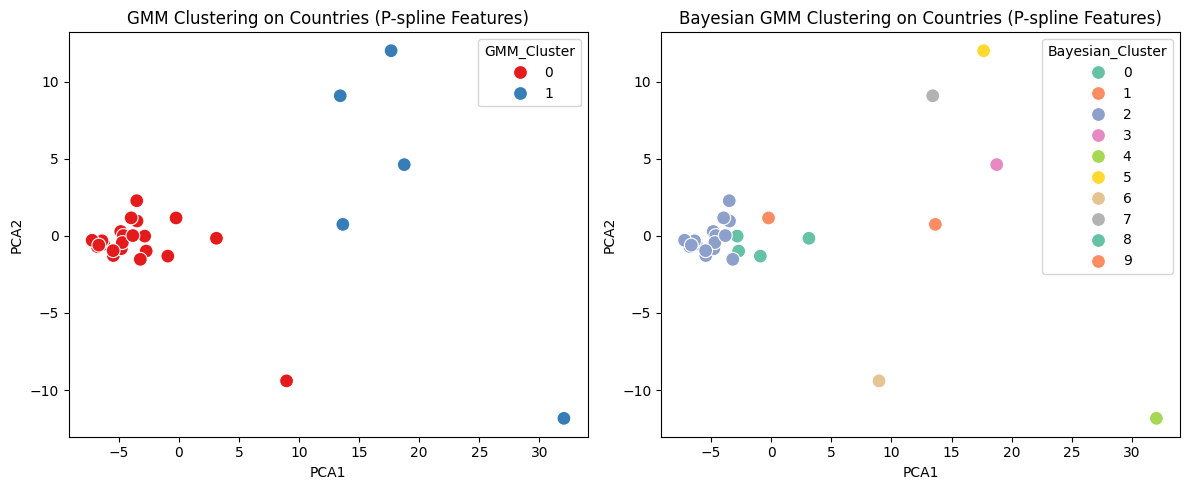

In [ ]:
# PCA projection for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pspline['PCA1'], X_pspline['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("GMM Clustering on Countries (P-spline Features)")
sns.scatterplot(data=X_pspline, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='Set1', s=100)

plt.subplot(1, 2, 2)
plt.title("Bayesian GMM Clustering on Countries (P-spline Features)")
sns.scatterplot(data=X_pspline, x='PCA1', y='PCA2', hue='Bayesian_Cluster', palette='Set2', s=100)

plt.tight_layout()
plt.show()

In [ ]:
# Step 9: Cluster Members
for cluster in sorted(X_pspline['Bayesian_Cluster'].unique()):
    print(f"\nBayesian Cluster {cluster}:")
    print(X_pspline[X_pspline['Bayesian_Cluster'] == cluster].index.tolist())


Bayesian Cluster 0:
['Greece']

Bayesian Cluster 1:
['Italy']

Bayesian Cluster 2:
['Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Norway', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

Bayesian Cluster 3:
['United Kingdom']

Bayesian Cluster 4:
['Germany']

Bayesian Cluster 5:
['France']

Bayesian Cluster 6:
['Poland']

Bayesian Cluster 7:
['Spain']

Bayesian Cluster 8:
['Austria', 'Belgium', 'Netherlands']

Bayesian Cluster 9:
['Czech Republic']


In [ ]:
# Step 9: Cluster Members
for cluster in sorted(X_pspline['GMM_Cluster'].unique()):
    print(f"\nGMM Cluster {cluster}:")
    print(X_pspline[X_pspline['GMM_Cluster'] == cluster].index.tolist())


GMM Cluster 0:
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'Greece', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

GMM Cluster 1:
['France', 'Germany', 'Italy', 'Spain', 'United Kingdom']


##  Spline evaluator

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_spline_fit(country, sector, df_spline, degree, alpha, spline_type="p-spline"):
    df_country = EU_data[EU_data["country"] == country].copy()
    df_country['t'] = np.arange(len(df_country))

    t = df_country['t'].values
    y = df_country[sector].values

    # Spline basis (same for B-spline and P-spline — only penalty differs)
    spline_basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                           {"t": t}, return_type='dataframe')

    # Ridge for P-spline (alpha > 0), LinearRegression for B-spline (alpha = 0)
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(spline_basis, y)
    y_smooth = model.predict(spline_basis)

    rmse = np.sqrt(mean_squared_error(y, y_smooth))
    mae = mean_absolute_error(y, y_smooth)
    r2 = r2_score(y, y_smooth)

    return {
        "spline_type": spline_type,
        "country": country,
        "sector": sector,
        "df": df_spline,
        "degree": degree,
        "alpha": alpha,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }


In [ ]:
b_eval = evaluate_spline_fit("Austria", "Industry", df_spline=20, degree=3, alpha=0.1, spline_type="b-spline")
p_eval = evaluate_spline_fit("Austria", "Industry", df_spline=20, degree=3, alpha=1.0, spline_type="p-spline")
print(b_eval)
print(p_eval)


{'spline_type': 'b-spline', 'country': 'Austria', 'sector': 'Industry', 'df': 20, 'degree': 3, 'alpha': 0.1, 'RMSE': np.float64(0.06826820946415672), 'MAE': 0.02884912775176005, 'R2': 0.09139334771625707}
{'spline_type': 'p-spline', 'country': 'Austria', 'sector': 'Industry', 'df': 20, 'degree': 3, 'alpha': 1.0, 'RMSE': np.float64(0.06827847383902753), 'MAE': 0.02870394332780669, 'R2': 0.09112010251230507}


In [ ]:
# Batch evaluator for multiple countries and sectors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from patsy import dmatrix
from sklearn.linear_model import Ridge

def batch_evaluate_spline(EU_data, df_spline, degree, alpha, spline_type):
    results = []
    sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
               'International Aviation', 'Power', 'Residential']
    countries = EU_data['country'].unique()

    for country in countries:
        df_country = EU_data[EU_data["country"] == country].copy()
        df_country['t'] = np.arange(len(df_country))

        t = df_country['t'].values

        for sector in sectors:
            y = df_country[sector].values

            # Spline basis
            spline_basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                                   {"t": t}, return_type='dataframe')

            model = Ridge(alpha=alpha, fit_intercept=False)
            model.fit(spline_basis, y)
            y_smooth = model.predict(spline_basis)

            rmse = np.sqrt(mean_squared_error(y, y_smooth))
            mae = mean_absolute_error(y, y_smooth)
            r2 = r2_score(y, y_smooth)

            results.append({
                "spline_type": spline_type,
                "country": country,
                "sector": sector,
                "df": df_spline,
                "degree": degree,
                "alpha": alpha,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2
            })

    return pd.DataFrame(results)


In [ ]:
# Evaluate both B-spline and P-spline across all countries and sectors
evaluation_p = batch_evaluate_spline(EU_data, df_spline=20, degree=3, alpha=1.0, spline_type="p-spline")
evaluation_b = batch_evaluate_spline(EU_data, df_spline=20, degree=3, alpha=0.1, spline_type="b-spline")

# Combine both evaluations
combined_evaluation = pd.concat([evaluation_p, evaluation_b], ignore_index=True)


# Summarize average metrics by spline type and sector
summary_table = combined_evaluation.groupby(['spline_type', 'sector'])[['RMSE', 'MAE', 'R2']].mean().reset_index()

# Round the values for cleaner display
summary_table[['RMSE', 'MAE', 'R2']] = summary_table[['RMSE', 'MAE', 'R2']].round(4)

# Display as a plain pandas table
summary_table.sort_values(by=['sector', 'spline_type'], inplace=True)
summary_table


spline_type                  sector    RMSE     MAE      R2
0     b-spline       Domestic Aviation  0.0002  0.0001  0.7146
6     p-spline       Domestic Aviation  0.0002  0.0001  0.7128
1     b-spline        Ground Transport  0.0055  0.0039  0.3967
7     p-spline        Ground Transport  0.0056  0.0041  0.3784
2     b-spline                Industry  0.0133  0.0093  0.1725
8     p-spline                Industry  0.0133  0.0093  0.1697
3     b-spline  International Aviation  0.0010  0.0007  0.9219
9     p-spline  International Aviation  0.0010  0.0007  0.9202
4     b-spline                   Power  0.0140  0.0109  0.6284
10    p-spline                   Power  0.0141  0.0109  0.6261
5     b-spline             Residential  0.0100  0.0077  0.8734
11    p-spline             Residential  0.0101  0.0077  0.8712

A comparative evaluation of B-splines (α=0.1) and P-splines (α=1.0) across six emission sectors revealed nearly indistinguishable performance in terms of RMSE and R². While B-splines showed marginally better results in Ground Transport and Residential sectors, P-splines offered the conceptual advantage of smoother, more regularized fits — aligning better with the Bayesian modeling framework adopted in this thesis. Both methods struggled with the Industry sector, likely due to its flat and low-variance signal structure, suggesting the need for alternate modeling techniques for this sector.

“Spline smoothing was applied to reduce noise and extract underlying CO₂ emission trends across six sectors using both B-spline and P-spline approaches. Comparative analysis showed minimal differences in fit quality — with B-splines (α = 0.1) offering marginally better RMSE and R² scores across most sectors. P-splines (α = 1.0), while slightly more conservative, aligned better with the Bayesian modeling framework due to their regularization characteristics.”

“However, spline-based modeling was less effective for the Industry sector, with both spline variants showing poor R² (~0.17). This indicated a flat signal with irregular, possibly structural, changes not well captured by global smoothing techniques. To address this, an alternative modeling approach was introduced — time-based regime clustering — aimed at detecting structural emission changes over time rather than across countries.”

# Part - 2 Workflow with mean smoothed



The complete workflow to apply smoothing on the the time series and then to cluster at country level.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt

Reloading the dataset

In [ ]:
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
print(EU_data.isna().sum())
EU_data.dropna(inplace=True)

country                   0
date                      0
Domestic Aviation         0
Ground Transport          0
Industry                  0
International Aviation    0
Power                     0
Residential               0
dtype: int64


## Preprocessing

In [ ]:
EU_data = EU_data[EU_data['country'] != 'EU27 & UK']
EU_data.dropna(inplace=True)


In [ ]:
EU_data.shape

(65760, 8)

In [ ]:
EU_data.head()

country       date  Domestic Aviation  Ground Transport  Industry  \
0  Austria 2019-01-01           0.000076          0.041154  0.013548   
1  Austria 2019-01-02           0.000081          0.046169  0.026430   
2  Austria 2019-01-03           0.000080          0.053560  0.034184   
3  Austria 2019-01-04           0.000093          0.057036  0.039000   
4  Austria 2019-01-05           0.000097          0.057139  0.036396   

   International Aviation     Power  Residential  
0                0.005584  0.018994     0.037810  
1                0.006003  0.037054     0.041709  
2                0.006447  0.047926     0.045371  
3                0.006512  0.054677     0.046992  
4                0.006652  0.051027     0.046546

## Smoothing Parameters

📐 P-spline smoothing (df=20, degree=3, α=1.0)

🎯 n=2 clusters (as determined optimal)

📊 BGMM modeling with posterior probabilities

🧠 Uncertainty assessment (max_prob < 0.8)

In [ ]:
# Parameters
alpha = 1.0  # Ridge regularization for p-spline
n_clusters = 2  # Optimal number of clusters
spline_degree = 3
spline_df = 20
spline_type = "p-spline"

# EU_data is preloaded and cleaned (no 'EU27 & UK')
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()

In [ ]:
# Building p-spline features per country
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']
countries = EU_data['country'].unique()

spline_features = []
country_labels = []

for country in countries:
    df_country = EU_data[EU_data['country'] == country].copy()
    df_country = df_country.sort_values('date')
    df_country['t'] = np.arange(len(df_country))

    country_vector = []
    for sector in sectors:
        t = df_country['t'].values
        y = df_country[sector].values
        basis = dmatrix(f"bs(t, df={spline_df}, degree={spline_degree}, include_intercept=True) - 1",
                        {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)
        country_vector.extend(y_smooth.mean().reshape(-1))

    spline_features.append(country_vector)
    country_labels.append(country)


In [ ]:
print(spline_features)

[[np.float64(0.00012410722512853328), np.float64(0.06531812935071576), np.float64(0.06619701524093159), np.float64(0.005434197455156051), np.float64(0.03204517999241219), np.float64(0.024240938749365448)], [np.float64(3.091541925146074e-05), np.float64(0.068559461993025), np.float64(0.07617606041069315), np.float64(0.011414199805233715), np.float64(0.039848174677459866), np.float64(0.06559689584422351)], [np.float64(4.554357854157884e-05), np.float64(0.025517796033633102), np.float64(0.01697221778935683), np.float64(0.0015589195521987019), np.float64(0.053865953618388446), np.float64(0.004458455859043582)], [np.float64(7.831293001116002e-05), np.float64(0.01569150440836832), np.float64(0.014016376540160004), np.float64(0.0012984990928060767), np.float64(0.00851761800439239), np.float64(0.00835215428876263)], [np.float64(9.865876167656934e-06), np.float64(0.005228359683226095), np.float64(0.004196803317998129), np.float64(0.0022083494559468207), np.float64(0.007406328623281363), np.floa

## BGMM on P-spline features

In [ ]:
X = np.array(spline_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
bgmm.fit(X_scaled)

BayesianGaussianMixture(n_components=2, random_state=42)

In [ ]:
print(X_scaled)

[[-5.31749377e-01 -1.59763913e-01  9.45729052e-02 -3.72571249e-01
  -3.40040010e-01 -3.67606058e-01]
 [-5.64953634e-01 -1.29277587e-01  2.37575398e-01 -1.64638267e-03
  -2.77296110e-01  1.07400967e-01]
 [-5.59741618e-01 -5.34105602e-01 -6.10832135e-01 -6.12945224e-01
  -1.64579113e-01 -5.94824070e-01]
 [-5.48065893e-01 -6.26526702e-01 -6.53190162e-01 -6.29098466e-01
  -5.29225196e-01 -5.50101756e-01]
 [-5.72453590e-01 -7.24937719e-01 -7.93907378e-01 -5.72662682e-01
  -5.38161076e-01 -6.20981204e-01]
 [ 5.97093763e-01 -3.02860260e-01 -1.40871447e-01 -2.67845372e-01
   3.48958548e-01 -2.58808109e-01]
 [-3.51732670e-01 -4.61574201e-01 -5.65407151e-01 -3.65592446e-01
  -4.38304813e-01 -5.16524044e-01]
 [-5.68524387e-01 -7.11280479e-01 -8.14154139e-01 -6.80157999e-01
  -4.27824125e-01 -6.22374059e-01]
 [-3.57978556e-01 -5.12546937e-01 -4.47836542e-01 -4.45454500e-01
  -3.57878331e-01 -5.27386153e-01]
 [ 3.73371569e+00  2.19758289e+00  1.40343796e+00  1.57459991e+00
  -4.47401395e-02  1.7784

In [ ]:
# Predicting cluster probabilities and assignments
probs = bgmm.predict_proba(X_scaled)
clusters = bgmm.predict(X_scaled)

# Building DataFrame of results
bgmm_results = pd.DataFrame({
    "country": country_labels,
    "cluster": clusters,
    "max_prob": probs.max(axis=1)
})

In [ ]:
print(bgmm_results)

           country  cluster  max_prob
0          Austria        0  1.000000
1          Belgium        0  1.000000
2         Bulgaria        0  0.999985
3          Croatia        0  0.999991
4           Cyprus        0  0.999995
5   Czech Republic        0  1.000000
6          Denmark        0  0.999940
7          Estonia        0  0.999987
8          Finland        0  0.999974
9           France        1  1.000000
10         Germany        1  1.000000
11          Greece        0  0.999999
12         Hungary        0  0.999986
13         Ireland        0  0.999983
14           Italy        1  1.000000
15          Latvia        0  0.999982
16       Lithuania        0  0.999997
17      Luxembourg        0  0.999963
18           Malta        0  0.999995
19     Netherlands        0  1.000000
20          Norway        0  1.000000
21          Poland        0  0.991852
22        Portugal        0  0.999110
23         Romania        0  1.000000
24        Slovakia        0  1.000000
25        Sl

In [ ]:
# Adding all posterior probabilities
for i in range(n_clusters):
    bgmm_results[f"prob_cluster_{i}"] = probs[:, i]

# Printing countries with low cluster certainty
uncertain = bgmm_results[bgmm_results['max_prob'] < 0.5]
print("Countries with uncertain cluster membership:")
print(uncertain)

Countries with uncertain cluster membership:
Empty DataFrame
Columns: [country, cluster, max_prob, prob_cluster_0, prob_cluster_1]
Index: []


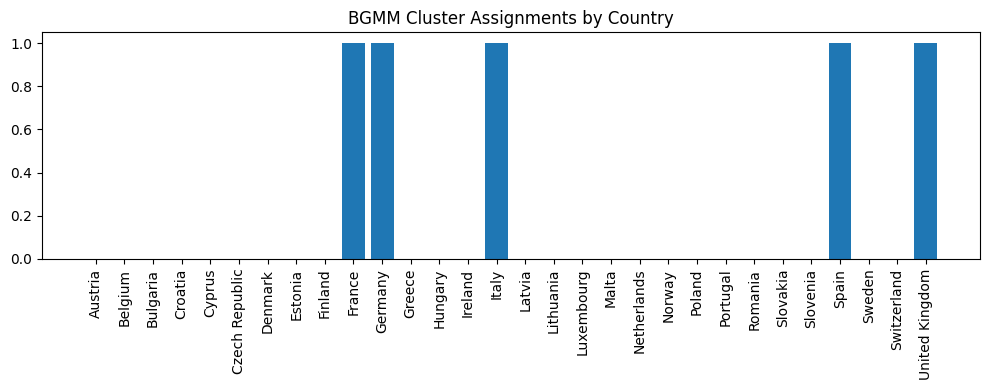

In [ ]:
# Visualizing cluster assignment
plt.figure(figsize=(10, 4))
plt.bar(bgmm_results['country'], bgmm_results['cluster'])
plt.title("BGMM Cluster Assignments by Country")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




In [ ]:
bgmm_results.sort_values(by='cluster')

#bgmm_results.to_csv("bgmm_results.csv") # Saving the cluster results

The posterior probabilities are extremely confident — almost all max_prob > 0.99.

The cluster separation is very sharp: prob for one cluster ≈ 1.0, other ≈ 0.

In [ ]:
# Converting clustering results into feature table
bgmm_feature_table = bgmm_results.rename(columns={
    'cluster': 'country_cluster',
    'prob_cluster_0': 'prob_country_cluster_0',
    'prob_cluster_1': 'prob_country_cluster_1'
})

bgmm_feature_table = bgmm_feature_table[[
    'country', 'country_cluster', 'prob_country_cluster_0', 'prob_country_cluster_1'
]]

bgmm_feature_table.head()

country  country_cluster  prob_country_cluster_0  prob_country_cluster_1
0   Austria                0                1.000000            2.021572e-19
1   Belgium                0                1.000000            5.133809e-13
2  Bulgaria                0                0.999985            1.472901e-05
3   Croatia                0                0.999991            9.236743e-06
4    Cyprus                0                0.999995            4.967828e-06

In [ ]:
bgmm_feature_table

country  country_cluster  prob_country_cluster_0  \
0          Austria                0            1.000000e+00   
1          Belgium                0            1.000000e+00   
2         Bulgaria                0            9.999853e-01   
3          Croatia                0            9.999908e-01   
4           Cyprus                0            9.999950e-01   
5   Czech Republic                0            1.000000e+00   
6          Denmark                0            9.999405e-01   
7          Estonia                0            9.999869e-01   
8          Finland                0            9.999738e-01   
9           France                1            3.581494e-88   
10         Germany                1            1.126575e-23   
11          Greece                0            9.999991e-01   
12         Hungary                0            9.999862e-01   
13         Ireland                0            9.999833e-01   
14           Italy                1            1.534195e-24   
15          Latvia                0            9.999824e-01   
16       Lithuania                0            9.999965e-01   
17      Luxembourg                0            9.999632e-01   
18           Malta                0            9.999954e-01   
19     Netherlands                0            1.000000e+00   
20          Norway                0            9.999997e-01   
21          Poland                0            9.918516e-01   
22        Portugal                0            9.991096e-01   
23         Romania                0            1.000000e+00   
24        Slovakia                0            1.000000e+00   
25        Slovenia                0            9.999841e-01   
26           Spain                1            9.762169e-23   
27          Sweden                0            9.999999e-01   
28     Switzerland                0            9.999650e-01   
29  United Kingdom                1            1.546241e-41   

    prob_country_cluster_1  
0             2.021572e-19  
1             5.133809e-13  
2             1.472901e-05  
3             9.236743e-06  
4             4.967828e-06  
5             5.956525e-20  
6             5.952401e-05  
7             1.309003e-05  
8             2.618346e-05  
9             1.000000e+00  
10            1.000000e+00  
11            9.371810e-07  
12            1.383741e-05  
13            1.667829e-05  
14            1.000000e+00  
15            1.761337e-05  
16            3.476521e-06  
17            3.680406e-05  
18            4.611070e-06  
19            6.903347e-23  
20            3.009666e-07  
21            8.148357e-03  
22            8.903534e-04  
23            1.957482e-08  
24            2.078491e-08  
25            1.590484e-05  
26            1.000000e+00  
27            1.036716e-07  
28            3.501390e-05  
29            1.000000e+00

## Cluster Visualization with Map

In [ ]:
import plotly.express as px

fig = px.choropleth(
    bgmm_feature_table,
    locations="country",
    locationmode="country names",
    color="country_cluster",
    hover_name="country",
    hover_data={
        "prob_country_cluster_0": ':.4f',
        "prob_country_cluster_1": ':.4f',
        "country_cluster": True
    },
    color_continuous_scale=px.colors.diverging.RdYlBu,
    title="Country Clusters Based on P-Spline + BGMM (With Posterior Probabilities)"
)

fig.update_layout(
    geo=dict(
        scope="europe",
        showframe=False,
        showcoastlines=True
    ),
    margin=dict(r=0, t=50, l=0, b=0)
)

fig.show()


For visual interpretation, country-level cluster assignments and their associated posterior probabilities were rendered as a choropleth map using Plotly’s native country name recognition. This approach ensures clean integration across all EU nations without requiring manual ISO-3 code mapping.

## Average Max Posterior Probabilty comparison

Here we compare the average max posterior probabilty of the two process we tried. Finding the optimal n based on Dirichlet process seems to be data-driven and is more adaptive to Bayesian framework yet its fragmentation tendency will have dispersed clusters. If we opt to go with n=2 that was supported from trails with BIC and Sil score we shall have a minimal ambiguity in cluster assignments.

In [ ]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Dirichlet Process BGMM (DP-based)
dp_bgmm = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior=0.5,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
)
dp_bgmm.fit(X_scaled)
dp_probs = dp_bgmm.predict_proba(X_scaled)
dp_max_probs = dp_probs.max(axis=1)
dp_avg_max_prob = np.mean(dp_max_probs)

# BGMM with fixed n=2
fixed_bgmm = BayesianGaussianMixture(
    n_components=2,
    #weight_concentration_prior_type='dirichlet_distribution',
    covariance_type='full',
    max_iter=1000,
    random_state=42
)
fixed_bgmm.fit(X_scaled)
fixed_probs = fixed_bgmm.predict_proba(X_scaled)
fixed_max_probs = fixed_probs.max(axis=1)
fixed_avg_max_prob = np.mean(fixed_max_probs)

# Result summary
pd.DataFrame({
    "Model": ["DP-BGMM (n=10)", "Fixed-BGMM (n=2)"],
    "Average Max Posterior Probability": [dp_avg_max_prob, fixed_avg_max_prob]
})


Model  Average Max Posterior Probability
0    DP-BGMM (n=10)                           0.997861
1  Fixed-BGMM (n=2)                           0.999690